In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-30 17:10:35.086970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-30 17:10:35.109863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 17:10:35.110125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-30 17:10:35.110239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-30 17:10:35.111288: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 17:10:35.112275: I tensorflow/stream_executor/platform/de

# Deep Deterministic Policy Gradient (DPG) Actor-Critic agents and How to Define Output layers

Deep Deterministic Policy Gracient (DDPG) is an Actor-Critic algorithm that tries to extend the DQN agents to create an agent for solving problems with continuous actions. This agent consist of two neural networks: 1) the Actor network receives states and propose actions and 2) the Critic network recieves the states and the actions to calculate the advantage values A(s, a).

Aditionally we will see how to define the output layers of each network when we use keras, since we let the library calculate it automatically until now.

In [2]:
from RL_Problem import rl_problem
from RL_Agent import ddpg_agent
from RL_Agent.base.utils import agent_saver, history_utils
from RL_Agent.base.utils.networks import networks
from RL_Problem.base.ActorCritic import ddpg_problem
from tensorflow.keras.layers import Dense, LSTM
import gym

2021-11-30 17:10:35.128109: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-11-30 17:10:35.132311: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3199980000 Hz
2021-11-30 17:10:35.132613: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f725590260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-30 17:10:35.132626: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-30 17:10:35.132766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 17:10:35.133041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeF

Here we are goin to define the neural network using keras. We created two functions, one for creating the actor network and aother for the critic network. When creating the critic network we have to take into acount that the network need two different inputs: 1) the state as usual in other agents. In this exmaple we stack 5 time steps and use as first layer an LSTM. And 2) the actions which consist of a array of 2 values because we have two actions in the selected environment.

Notice that we also define an output layer, this allows the user to define for example their prefered activation, add a normalization in the output or even use a Lambda function to sample from a normal distribution.

In [3]:
def actor_custom_model(input_shape):
    lstm = LSTM(32, activation='tanh', input_shape=input_shape, name='lstm_c')
    dense_1 = Dense(256, activation='relu')
    dense_2 = Dense(128, activation='relu')
    
    # Output layer
    output = Dense(2, activation='tanh')
    
    def model():
        model = tf.keras.models.Sequential([lstm, dense_1, dense_2, output])
        return model
    return model()

def critic_custom_model(input_shape, actor_net):
    
    lstm_s = LSTM(32, activation='tanh', input_shape=input_shape, name='lstm_state')
    dense_s = Dense(256, activation='relu', name='dense_state')
    
    dense_a = Dense(128, activation='relu', input_shape=(actor_net.output.shape[1:]), name='dense_act')
    
    dense_c = Dense(128, activation='relu', name='dense_common')
    output = Dense(1, activation='linear', name='output')
    
    def model():
        
        # state model
        state_model = tf.keras.models.Sequential([lstm_s, dense_s])   
        
        # action model
        act_model = tf.keras.models.Sequential([dense_a])
        
        # merge both models
        merge = tf.keras.layers.Concatenate()([state_model.output, act_model.output])
        merge = dense_c(merge)
        
        # Output layer
        out = output(merge)
        
        model = tf.keras.models.Model(inputs=[state_model.input, act_model.input], outputs=out)
        return model
    return model()

In the next cell, we define the neural network using dictionaries. As we have especified the output layers for Actor and Critic we have to set to True the "define_custom_output_layer" to inform the agent of this fact. We also need to set to True the "use_custom_network" param.

In [4]:
net_architecture = networks.ddpg_net(use_custom_network=True,
                                     actor_custom_network=actor_custom_model,
                                     critic_custom_network=critic_custom_model,
                                     define_custom_output_layer=True)

We build the actor-critic agent when we have two learning rates, one for each network.

In [9]:
agent = ddpg_agent.Agent(actor_lr=1e-3,
                         critic_lr=1e-3,
                         batch_size=64,
                         epsilon=0.5,
                         epsilon_decay=0.9999,
                         epsilon_min=0.15,
                         net_architecture=net_architecture,
                         n_stack=5)

Define the environment.

In [10]:
environment = "LunarLanderContinuous-v2"
environment = gym.make(environment)

Create the problem.

In [11]:
problem = ddpg_problem.DDPGPRoblem(environment, agent)

Solving the RL problem.

In [12]:
problem.solve(200, render=False, max_step_epi=200, render_after=150, skip_states=6)


Episode:  1 Epochs:  83  Reward: -208.4 Smooth Reward: -208.4  Epsilon: 0.5000
Episode:  2 Epochs:  90  Reward: -309.9 Smooth Reward: -259.2  Epsilon: 0.5000
Episode:  3 Epochs:  141  Reward: -498.3 Smooth Reward: -338.9  Epsilon: 0.5000
Episode:  4 Epochs:  71  Reward: -69.8 Smooth Reward: -271.6  Epsilon: 0.4999
Episode:  5 Epochs:  81  Reward: -741.8 Smooth Reward: -365.6  Epsilon: 0.4992
Episode:  6 Epochs:  116  Reward: -1004.9 Smooth Reward: -472.2  Epsilon: 0.4982
Episode:  7 Epochs:  58  Reward: -75.5 Smooth Reward: -415.5  Epsilon: 0.4977
Episode:  8 Epochs:  68  Reward: -344.9 Smooth Reward: -406.7  Epsilon: 0.4971
Episode:  9 Epochs:  68  Reward: -505.0 Smooth Reward: -417.6  Epsilon: 0.4965
Episode:  10 Epochs:  71  Reward: -471.0 Smooth Reward: -423.0  Epsilon: 0.4959
Episode:  11 Epochs:  54  Reward: -383.6 Smooth Reward: -440.5  Epsilon: 0.4955
Episode:  12 Epochs:  76  Reward: -532.8 Smooth Reward: -462.8  Epsilon: 0.4948
Episode:  13 Epochs:  68  Reward: -124.0 Smooth 

Episode:  105 Epochs:  58  Reward: -224.4 Smooth Reward: -591.2  Epsilon: 0.4361
Episode:  106 Epochs:  78  Reward: -546.0 Smooth Reward: -584.2  Epsilon: 0.4355
Episode:  107 Epochs:  107  Reward: -816.2 Smooth Reward: -609.4  Epsilon: 0.4347
Episode:  108 Epochs:  84  Reward: -569.7 Smooth Reward: -599.2  Epsilon: 0.4341
Episode:  109 Epochs:  64  Reward: -687.2 Smooth Reward: -567.8  Epsilon: 0.4336
Episode:  110 Epochs:  72  Reward: -624.9 Smooth Reward: -575.3  Epsilon: 0.4331
Episode:  111 Epochs:  88  Reward: -884.4 Smooth Reward: -622.4  Epsilon: 0.4325
Episode:  112 Epochs:  99  Reward: -869.8 Smooth Reward: -614.8  Epsilon: 0.4317
Episode:  113 Epochs:  88  Reward: -573.6 Smooth Reward: -645.1  Epsilon: 0.4311
Episode:  114 Epochs:  102  Reward: -460.1 Smooth Reward: -625.6  Epsilon: 0.4304
Episode:  115 Epochs:  91  Reward: -819.4 Smooth Reward: -685.1  Epsilon: 0.4297
Episode:  116 Epochs:  87  Reward: -757.5 Smooth Reward: -706.3  Epsilon: 0.4290
Episode:  117 Epochs:  71 

Run the agent in test mode to see the final performance

In [13]:
problem.test(render=True, n_iter=5)


Test episode:  1 Epochs:  68  Reward: -746.7 Smooth Reward: -746.7  Epsilon: 0.3843
Test episode:  2 Epochs:  57  Reward: -531.1 Smooth Reward: -638.9  Epsilon: 0.3843
Test episode:  3 Epochs:  84  Reward: -676.6 Smooth Reward: -651.4  Epsilon: 0.3843
Test episode:  4 Epochs:  50  Reward: -376.3 Smooth Reward: -582.7  Epsilon: 0.3843
Test episode:  5 Epochs:  57  Reward: -603.4 Smooth Reward: -586.8  Epsilon: 0.3843


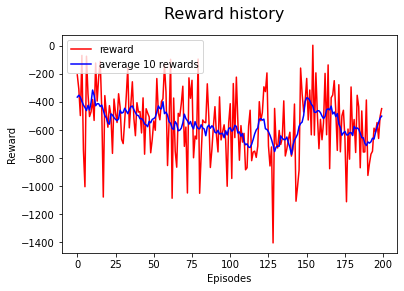

In [14]:
hist = problem.get_histogram_metrics()
history_utils.plot_reward_hist(hist, 10)